In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac4ae04f-aa7b-d47b-82be-1ec6339652be)


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [5]:
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
train_one_sample = train_data.take(2)

In [7]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 8
  Class name (str form): bread_pudding
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 45
  Class name (str form): frozen_yogurt
        


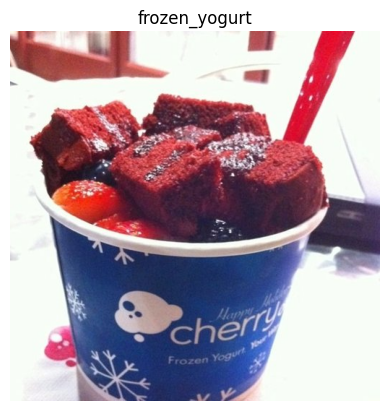

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [9]:
def preprocess_img(image,label,img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [10]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[253 252 234]
  [254 253 235]
  [254 253 235]
  ...
  [248 253 247]
  [248 253 247]
  [248 253 247]]

 [[252 249 232]
  [252 249 232]
  [253 250 233]
  ...
  [248 253 247]
  [248 253 247]
  [248 253 247]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[252.58673 250.30103 232.94388]
  [254.28572 252.      234.64285]
  [254.49489 245.57143 227.13776]
  ...
  [248.      253.      247.     ]
  [248.      253.      247.     ]
  [248.      253.      247.     ]]

 [[251.94897 237.31122 226.57143]
  [253.07654 239.64796 226.43367]
  [252.94388 234.57143 220.37245]
  ...
  [248.      253.      247.     ]
  [248.      253.      247.     ]
  [248.      253.      247.     ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


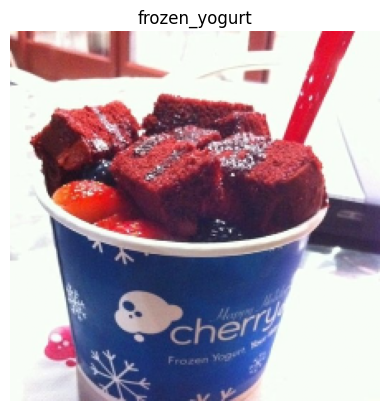

In [11]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);


In [12]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [14]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [15]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,name='input_layer')
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax",dtype=tf.float32,name='softmax_32')(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

base_model.summary()

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [17]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
2368/2368 [==============================] - 187s 73ms/step - loss: 1.7171 - accuracy: 0.5838 - val_loss: 1.1247 - val_accuracy: 0.6992
Epoch 2/5
2368/2368 [==============================] - 163s 68ms/step - loss: 1.1989 - accuracy: 0.6900 - val_loss: 1.0342 - val_accuracy: 0.7119
Epoch 3/5
2368/2368 [==============================] - 163s 68ms/step - loss: 1.0547 - accuracy: 0.7247 - val_loss: 0.9842 - val_accuracy: 0.7291
Epoch 4/5
2368/2368 [==============================] - 179s 75ms/step - loss: 0.9597 - accuracy: 0.7470 - val_loss: 0.9706 - val_accuracy: 0.7352
Epoch 5/5
2368/2368 [==============================] - 173s 72ms/step - loss: 0.8899 - accuracy: 0.7645 - val_loss: 0.9610 - val_accuracy: 0.7346


In [18]:
model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 0.9731 - accuracy: 0.7331


[0.9731392860412598, 0.7331485152244568]

In [19]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))


  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

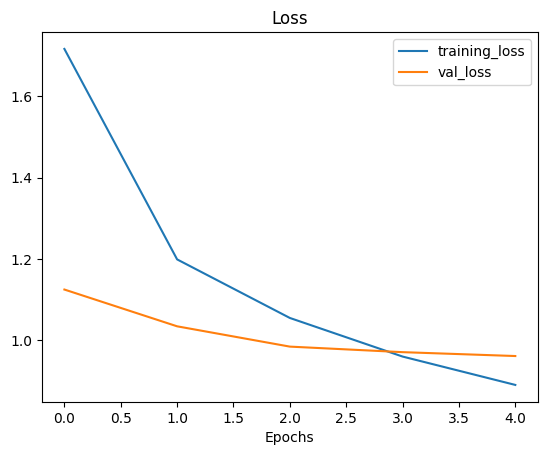

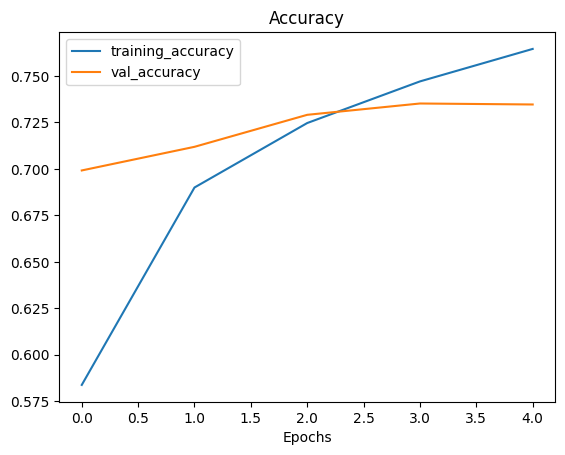

In [20]:
loss_curves=plot_loss_curves(history)

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path):


    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [47]:
import numpy as np

def load_and_preprocess_image(image_path, target_size=(224, 224,3)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

def predict_image_class(model, image_path, class_names):

    img = load_and_preprocess_image(image_path)


    predictions = model.predict(np.expand_dims(img, axis=0))


    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]

    return predicted_class







1/1 [==============================] - 0s 38ms/step


'pizza'

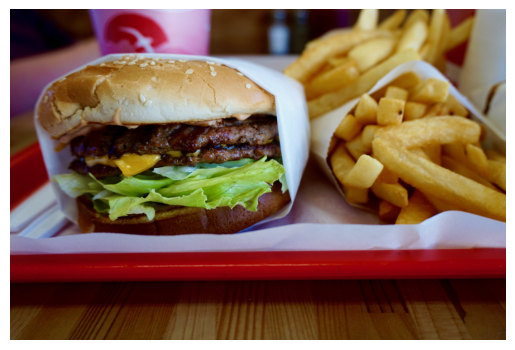

In [54]:
image_path = 'img_1.jpeg'
display_image(image_path)

In [55]:
image_path = 'img_1.jpeg'
predict_image_class(model, image_path, class_names)

1/1 [==============================] - 0s 27ms/step


'hamburger'

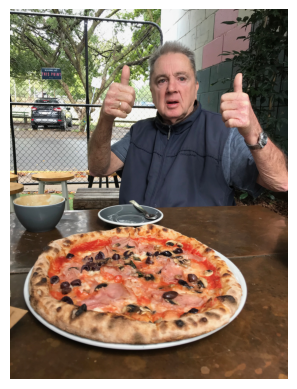

In [56]:
image_path = 'img_2.jpeg'
display_image(image_path)

In [57]:
image_path = 'img_2.jpeg'
predict_image_class(model, image_path, class_names)

1/1 [==============================] - 0s 51ms/step


'pizza'